# Miniproject: Landing on the Moon

## Introduction

### Description

Traditionally, reinforcement learning has operated on "tabular" state spaces, e.g. "State 1", "State 2", "State 3" etc. However, many important and interesting reinforcement learning problems (like moving robot arms or playing Atari games) are based on either continuous or very high-dimensional state spaces (like robot joint angles or pixels). Deep neural networks constitute one method for learning a value function or policy from continuous and high-dimensional observations. 

In this miniproject, you will teach an agent to play the Lunar Lander game from [OpenAI Gym](https://gym.openai.com/envs/LunarLander-v2/). The agent needs to learn how to land a lunar module safely on the surface of the moon. The state space is 8-dimensional and (mostly) continuous, consisting of the X and Y coordinates, the X and Y velocity, the angle, and the angular velocity of the lander, and two booleans indicating whether the left and right leg of the lander have landed on the moon.

The agent gets a reward of +100 for landing safely and -100 for crashing. In addition, it receives "shaping" rewards at every step. It receives positive rewards for moving closer to [0,0], decreasing in velocity, shifting to an upright angle and touching the lander legs on the moon. It receives negative rewards for moving away from the landing site, increasing in velocity, turning sideways, taking the lander legs off the moon and for using fuel (firing the thrusters). The best score an agent can achieve in an episode is about +250.

There are two versions of the task: one with discrete controls and one with continuous controls but we'll only work with the discrete version. In the discrete version, the agent can take one of four actions at each time step: [do nothing, fire engines left, fire engines right, fire engines down]. 

We will use Policy Gradient approaches (using the REINFORCE rule) to learn the task. As you remember, in standard supervised learning tasks (e.g. image classification), the network generates a probability distribution over the outputs, and is trained to maximize the probability of a specific target output given an observation (input). In Policy Gradient methods, the network generates a probability distribution over actions, and is trained to maximize expected future rewards given an observation.

### Questions
**Question 1**. Suppose that you are designing the environment rewards yourself. Why do you think it is a good idea to have rewards in addition to the +100 reward for safe landing (e.g. for moving closer / further from [0, 0], for touching the lander legs on the moon)? One might say that if we only have a final reward, the agent will still be able to learn how to reach it. What will be the problem here?

**Answer**: These additional rewards award actions that are coherent with common sense knowledge, thus narrowing down the otherwise very large state space. As a matter of fact, the agent might have to explore a huge number of possible paths (growing exponentially in the number of steps in the episode) before safely landing nearby [0, 0] and getting its first positive reward. It could still be potentially possible to learn the task without any reward shaping, but it would take a considerably longer time.


**Question 2**. Now suppose you decide to give the agent a small reward if it moves closer to the landing point but you forget to penalize it when it moves away from it. What kinds of strange behaviour you may observe from the trained agent?

**Answer**: The agent could learn to go up and down in an long-lasting loop. This could happen because it would receive positive rewards by going down and not get any penalization while going up again, and potentially yield an infinite reward, bounded only by the maximum episode length.


### Prerequisites

- Since you are using Colab, everything is pre-installed, and you just need to run the cells. However, be careful with computational limits: any kernel in an *open* browser window is killed after 12 hours, and after 90 minutes if the window is **closed**.

- You can work in the same notebook within your team, but make sure to copy (this) notebook provided by TAs into your Google Drive and to use the proper sharing permissions.
  
- You should know the concepts of "policy", "policy gradient", "REINFORCE", "REINFORCE with baseline". If you want to start and haven't seen these yet in class, read Sutton & Barto (2018) Chapter 13 (13.1-13.4).

### What you will learn

- You will learn how to implement a policy gradient neural network using the REINFORCE algorithm.
- You will learn how to implement baselines, including a learned value network.
- You will learn how to analyze the performance of an RL algorithm.

### Notes 
- Reinforcement learning is noisy! Normally one should average over multiple random seeds with the same parameters to really see the impact of a change to the model, but we won't do this due to time constraints. However, you should be able to see learning over time with every approach. If you don't see any improvement, or very unstable learning, double-check your model and try adjusting the learning rate.

- You may sometimes see `AssertionError: IsLocked() = False` after restarting your code. To fix this, reinitialize the environments by running the Gym Setup code below.

- You will not be marked on the episode movies. Please delete these movies before uploading your code.

### Evaluation criteria

The miniproject is marked out of 18, with a further mark breakdown in each question:
- Exercise 1: 7 points
- Exercise 2: 3 points
- Exercise 3: 3 points
- Exercise 4: 5 points

We may perform random tests of your code but will not rerun the whole notebook.

## Dependencies Setup
Please run the following cell to install the required packages. Note that you may be asked to restart the notebook. After restarting and reruning the cells, everything should work.

In [ ]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip3 install box2d-py > /dev/null 2>&1
!pip3 install gym[Box_2D] pyvirtualdisplay > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

### Your Names

Before you start, please enter your sciper number(s) in the field below; they are used to load the data.

In [ ]:
sciper = {'student_1': 313423, 
          'student_2': 313740}
seed = sciper['student_1']+sciper['student_2']

## Setup

### Dependencies and constants

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import logging
import io
import base64

from IPython import display as ipythondisplay
from IPython.display import HTML, clear_output

from matplotlib.animation import FuncAnimation
from pyvirtualdisplay import Display
from gym.envs.box2d.lunar_lander import heuristic
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
import keras
import tensorflow as tf
# from tensorflow_probability.distributions import Beta
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Lambda, InputLayer
from keras.optimizers import Adam
from keras import backend as K

np.random.seed(seed)
tf.random.set_seed(seed*2)

### Gym Setup

Here we load the Reinforcement Learning environments from Gym.

We limit each episode to 500 steps so that we can train faster. 

In [ ]:
gym.logger.setLevel(logging.ERROR)
discrete_env = gym.make('LunarLander-v2')
discrete_env._max_episode_steps = 500
discrete_env.seed(seed*3)
gym.logger.setLevel(logging.WARN)

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams["animation.html"] = "jshtml"

### Utilities

We include a function that lets you visualize an "episode" (i.e. a series of observations resulting from the actions that the agent took in the environment).

As well, we will use the `Results` class (a wrapper around a python dictionary) to store, save, load and plot your results. You can save your results to disk with `results.save('filename')` and reload them with `Results(filename='filename')`. Use `results.pop(experiment_name)` to delete an old experiment.

In [ ]:
def render(episode, env):
    
    fig = plt.figure()
    img = plt.imshow(env.render(mode='rgb_array'))
    plt.axis('off')

    def animate(i):
        img.set_data(episode[i])
        return img,

    anim = FuncAnimation(fig, animate, frames=len(episode), interval=24, blit=True)
    html = HTML(anim.to_jshtml())
    
    plt.close(fig)
    !rm None0000000.png
    
    return html

class Results(dict):
    
    def __init__(self, *args, **kwargs):
        if 'filename' in kwargs:
            data = np.load(kwargs['filename'])
            super().__init__(data)
        else:
            super().__init__(*args, **kwargs)
        self.new_key = None
        self.plot_keys = None
        self.ylim = None
        
    def __setitem__(self, key, value):
        super().__setitem__(key, value)
        self.new_key = key

    def plot(self, window):
        clear_output(wait=True)
        for key in self:
            #Ensure latest results are plotted on top
            if self.plot_keys is not None and key not in self.plot_keys:
                continue
            elif key == self.new_key:
                continue
            self.plot_smooth(key, window)
        if self.new_key is not None:
            self.plot_smooth(self.new_key, window)
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend(loc='lower right')
        if self.ylim is not None:
            plt.ylim(self.ylim)
        plt.show()
        
    def plot_smooth(self, key, window):
        if len(self[key]) == 0:
            plt.plot([], [], label=key)
            return None
        y = np.convolve(self[key], np.ones((window,))/window, mode='valid')
        x = np.linspace(window/2, len(self[key]) - window/2, len(y))
        plt.plot(x, y, label=key)
        
    def save(self, filename='results'):
        np.savez(filename, **self)

### Test runs

To get an idea of how the environment works, we'll plot an episode resulting from random actions at each point in time, and a "perfect" episode using a specially-designed function to land safely within the yellow flags. 

Please remove these plots before submitting the miniproject to reduce the file size.

In [ ]:
def run_fixed_episode(env, policy):
    frames = []
    observation = env.reset()
    done = False
    while not done:
        frames.append(env.render(mode='rgb_array'))
        action = policy(env, observation)
        observation, reward, done, info = env.step(action)
    return frames
    
def random_policy(env, observation):
    return env.action_space.sample()

def heuristic_policy(env, observation):
    return heuristic(env.unwrapped, observation)


In [ ]:
episode = run_fixed_episode(discrete_env, random_policy)
render(episode, discrete_env)

In [ ]:
episode = run_fixed_episode(discrete_env, heuristic_policy)
render(episode, discrete_env)

## Experiment Loop

This is the method we will call to setup an experiment. Reinforcement learning usually operates on an Observe-Decide-Act cycle, as you can see below.

You don't need to add anything here; you will be working directly on the RL agent.

In [ ]:
num_episodes = 3000
episodes_landed = []

def run_experiment(experiment_name, 
                   env,
                   num_episodes, 
                   policy_learning_rate=0.001, 
                   value_learning_rate=0.001, 
                   baseline=None, 
                   entropy_cost=0, 
                   max_ent_cost=0, 
                   num_layers=3,
                   mean_decay=0.1):  # We added this parameter to test different decays for the exponential moving average

    #Initiate the learning agent
    agent = RLAgent(n_obs=env.observation_space.shape[0], 
                    action_space=env.action_space,
                    policy_learning_rate=policy_learning_rate, 
                    value_learning_rate=value_learning_rate, 
                    discount=0.99, 
                    baseline=baseline, 
                    entropy_cost=entropy_cost, 
                    max_ent_cost=max_ent_cost,
                    num_layers=num_layers,
                    mean_decay=mean_decay)

    rewards = []
    all_episode_frames = []
    step = 0
    for episode in range(1, num_episodes+1):
    
        #Update results plot and occasionally store an episode movie
        episode_frames = None
        if episode % 10 == 0:
            results[experiment_name] = np.array(rewards)
            results.plot(10)
        if episode % 500 == 0:
            episode_frames = []
            
        #Reset the environment to a new episode
        observation = env.reset()
        episode_reward = 0

        while True:
        
            if episode_frames is not None:
                episode_frames.append(env.render(mode='rgb_array'))

            # 1. Decide on an action based on the observations
            action = agent.decide(observation)

            # 2. Take action in the environment
            next_observation, reward, done, info = env.step(action)
            episode_reward += reward

            # 3. Store the information returned from the environment for training
            agent.observe(observation, action, reward)

            # 4. When we reach a terminal state ("done"), use the observed episode to train the network
            if done:
                rewards.append(episode_reward)
                if episode_frames is not None:
                    all_episode_frames.append(episode_frames)
                agent.train()
                break

            # Reset for next step
            observation = next_observation
            step += 1
    
    return all_episode_frames, agent

## The Agent

Here we give the outline of a python class that will represent the reinforcement learning agent (along with its decision-making network). We'll modify this class to add additional methods and functionality throughout the course of the miniproject.


In [ ]:
class RLAgent(object):
    
    def __init__(self, n_obs, action_space, policy_learning_rate, value_learning_rate, 
                 discount, baseline = None, entropy_cost = 0, max_ent_cost = 0, num_layers=3, mean_decay=0.1):

        self.n_obs = n_obs  # size of the state
        self.n_act = action_space.n  # number of actions
        
        self.plr = policy_learning_rate 
        self.vlr = value_learning_rate
        self.gamma = discount  # discount factor
        self.num_layers = num_layers
        self.mean_decay = mean_decay  # decay factor of the mean in case we use simple baseline
        self.prev_mean_num = 0  # numerator of the exponential moving average
        self.prev_mean_den = 0  # denominator of the exponential moving average
        self.epoch = 0

        self.use_baseline = baseline is not None
        self.use_adaptive_baseline = baseline == 'adaptive'

        self.policy_loss = keras.losses.SparseCategoricalCrossentropy()
        self.policy_optimizer = Adam(learning_rate=self.plr)
        self.value_loss = keras.losses.MeanSquaredError()
        self.value_optimizer = Adam(learning_rate=self.vlr)

        # These lists stores the cumulative observations for this episode
        self.episode_observations, self.episode_actions, self.episode_rewards = [], [], []

        # Build the keras network
        self._build_network()

    def observe(self, state, action, reward):
        """ This function takes the observations the agent received from the environment and stores them
            in the lists above."""
        self.episode_observations.append(state)
        self.episode_actions.append(action)
        self.episode_rewards.append(reward)
        
    def decide(self, state):
        """ This function feeds the observed state to the network, which returns a distribution
            over possible actions. Sample an action from the distribution and return it."""
        
        # Create the input (should be 2-D due to Keras usage)
        batch_input = np.expand_dims(state, 0)
        
        # Compute the policy network output, unpack the 2-D result
        (network_output,) = self.policy_net(batch_input).numpy()

        # Sample action from the output distribution of the policy network
        chosen_action = np.random.choice(self.n_act, p=network_output)
        
        return chosen_action

    def train(self):
        """ When this function is called, the accumulated episode observations, actions and discounted rewards
            should be fed into the network and used for training. Use the _get_returns function to first turn 
            the episode rewards into discounted returns. 
            Apply simple or adaptive baselines if needed, depending on parameters."""
        
        inputs = np.array(self.episode_observations)

        # Compute the discounted rewards
        returns = self._get_returns()

        # Compute the baseline
        if self.use_baseline:
            if self.use_adaptive_baseline:
                # Use adaptive baseline
                baseline = self.value_net(inputs).numpy()[:, 0]
            else:
                # Use simple baseline
                self.prev_mean_num = np.mean(returns) + self.mean_decay * self.prev_mean_num
                self.prev_mean_den +=  self.mean_decay ** self.epoch
                baseline = self.prev_mean_num / self.prev_mean_den
        else:
            baseline = 0

        # Subtract the baseline
        diff = returns - baseline

        # We tried to multiply the discounted rewards by gamma ^ t, but we had a poorer performance
        # than without this multiplication, hence we decided to not keep it in the final version
        # final_discount = self.gamma ** np.arange(returns.shape[0])
        # diff *= final_discount

        targets = np.array(self.episode_actions)
                
        # Train the policy network
        self.policy_net.train_on_batch(
            inputs, targets, sample_weight=diff
        )
        
        # If we are using adaptive baseline, train the value network
        if self.use_baseline and self.use_adaptive_baseline:
            self.value_net.train_on_batch(
                inputs, returns  # , sample_weight=final_discount # since we decided to not multiply by gamma ^ t, 
                                                                 # to be consintent we remove it as weight for 
                                                                 # the train of the value net as well
            )

        self.episode_observations, self.episode_actions, self.episode_rewards = [], [], []
        self.epoch += 1

    def _get_returns(self):
        """ This function should process self.episode_rewards and return the discounted episode returns
            at each step in the episode. Hint: work backwards."""
        
        returns = [self.episode_rewards[-1]]
        
        # Recursively compute the discounted rewards
        for r in reversed(self.episode_rewards[:-1]):
            g = r + returns[-1] * self.gamma
            returns.append(g)
        
        # Invert the array of returns
        return np.array(returns[::-1])

    def _build_network(self):
        """ This function should build the network that can then be called by decide and train. 
            The network takes observations as inputs and has a policy distribution as output."""
        
        inputs = Input(shape=(self.n_obs,))

        # Policy network
        prev_layer = inputs
        for _ in range(self.num_layers):
            curr_layer = Dense(16, activation='relu')(prev_layer)
            prev_layer = curr_layer
        action = Dense(self.n_act, activation='softmax')(prev_layer)
        self.policy_net = Model(inputs=inputs, outputs=action)
        self.policy_net.compile(loss=self.policy_loss, optimizer=self.policy_optimizer)

        # Value network
        if self.use_baseline and self.use_adaptive_baseline:
            prev_layer = inputs
            for _ in range(self.num_layers):
                curr_layer = Dense(16, activation='relu')(prev_layer)
                prev_layer = curr_layer
            value = Dense(1, activation='linear')(prev_layer)
            self.value_net = Model(inputs=inputs, outputs=value)
            self.value_net.compile(loss=self.value_loss, optimizer=self.value_optimizer)

## Exercise 1: REINFORCE with simple baseline

### Description

Implement the REINFORCE Policy Gradient algorithm using a deep neural network as a function approximator.

1. Implement the `observe` method of the RLAgent above.
2. Implement the `_build_network` method. Your network should take the 8-dimensional state space as input and output a softmax distribution over the 4 discrete actions. It should have 3 hidden layers with 16 units each with ReLU activations. Use the REINFORCE loss function. HINT: Keras has a built-in "categorical cross-entropy" loss, and a `sample_weight` argument in fit/train_on_batch. Consider how these could be used together.
3. Implement the `decide`, `train` and `_get_returns` methods using the inputs and outputs of your network. In `train`, implement a baseline based on a moving average (over episodes) of the mean returns (over trials of one episode); it should only be in effect when the agent is constructed with the `use_simple_baseline` keyword. Also, use `train_on_batch` to form one minibatch from all the experiences in an episode. Hint: see Question 2) below.
4. Try a few learning rates and pick the best one (the default for Adam is a good place to start). Run the functions below and include the resulting plots, with and without the baseline, for your chosen learning rate. 
5. Answer the questions below in max. 1-2 sentence(s).

WARNING: Running any experiments with the same names (first argument in run_experiment) will cause your results to be overwritten. 

**Mark breakdown: 7 points total**
- 5 points for implementing and plotting basic REINFORCE with reasonable performance (i.e. a positive score) and answering the questions below.
- 2 points for implementing and plotting the simple baseline with reasonable performance.

### Solution

### No baseline

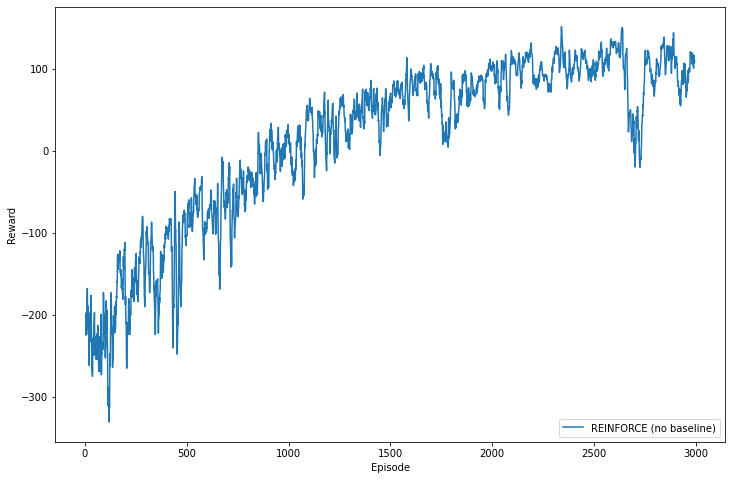

In [ ]:
results = Results()
episodes, agent = run_experiment("REINFORCE (no baseline)", discrete_env, num_episodes, 0.002)
# results.save("ann_experiments/final_results")

Even though very simple, the network using no baseline still manages to get a positive reward at the end of the training (close to 100).

### Simple baseline

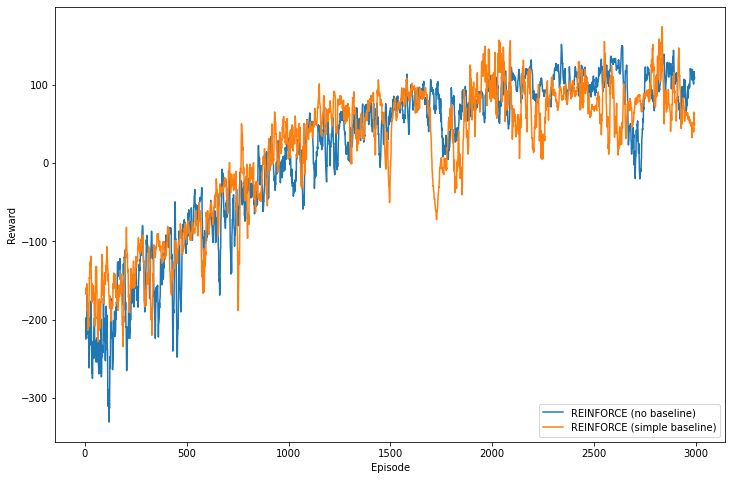

In [ ]:
# results = Results(filename="ann_experiments/final_results.npz")
episodes, agent = run_experiment("REINFORCE (simple baseline)", discrete_env, num_episodes, policy_learning_rate=0.002, baseline='simple', mean_decay=0.9)
# results.save("ann_experiments/final_results")

As we can see in the appendix, the network with mean decay 0.9 can achieve good performances, but at the cost of a higher variance. This is evident also in this plot, because it reached peaks that are higher than the no baseline network, but it is still noisy.

**Question 1**: We have at least three posibilities of picking the action: i) sample an action according to the softmax distribution, ii) select action with max action probability and iii) use an epsilon-greedy strategy. What is the difference between these strategies and which one(s) is(are) preferable during training and which one(s) is(are) preferable during testing?. 


**Answer**: We can either choose to exploit the current knowledge by always picking the best action using a greedy policy (which can get stuck in a bad local minimum), or explore a bigger state space by taking in account the other (temporarily considered suboptimal) actions via a $\varepsilon$-greedy or softmax policy. During training it is better to explore the state space via $\varepsilon$-greedy or softmax, while at test time it is better to exploit the learned knowledge using a greedy policy.

**Question 2**: In the train method above we throw away the data from an episode after we use it to train the network (make sure that you do that). Why is it not a good idea to keep the old episodes and train the policy network on both old and new data? (Note: Reusing data can still be possible but requires modifications to the REINFORCE algorithm that we are using).

**Answer**: It is not a good idea because, by considering old data (i.e. state-action pairs), we would give it a biased statistical weight. As a result, the gradient updates would be consequently biased by the state-action pairs encountered in previous episodes, no matter how rare they are in reality, since they would be provided as inputs over and over in time.

## Exercise 2: Adaptive baseline
### Description

Add a second neural network to your model that learns an observations-dependent adaptive baseline and subtracts it from your discounted returns.

1. Modify the `_build_network` function of RLAgent to create a second "value network" when `adaptive` is passed for the baseline argument. The value network should have the same or similar structure as the policy network, without the softmax at the output.
3. In addition to training your policy network, train the value network on the Mean-Squared Error compared to the discounted returns.
4. Train your policy network on $R - b(s)$, i.e. the returns minus the adaptive baseline (the output of the value network). Your implementation should allow for a different learning rate for the value and policy network.
5. Try a few learning rates and plot all your best results together (without baseline, with simple baseline, with adaptive baseline). You may or may not be able to improve on the simple baseline! Return the trained model to use it in the next exercise.

TECHNICAL NOTE: Some textbooks may refer to this approach as "Actor-Critic", where the policy network is the "Actor" and the value network is the "Critic". Sutton and Barto (2018) suggest that Actor-Critic only applies when the discounted returns are bootstrapped from the value network output, as you saw in class. This can introduce instability in learning that needs to be addressed with more advanced techniques, so we won't use it for this miniproject. You can read more about state-of-the-art Actor-Critic approaches here: https://arxiv.org/pdf/1602.01783.pdf

**Mark breakdown: 3 points total**
- 3 points for implementing and plotting the adaptive baseline with the other two conditions, with reasonable performance (i.e. at least similar to the performance in Exercise 1).

### Solution

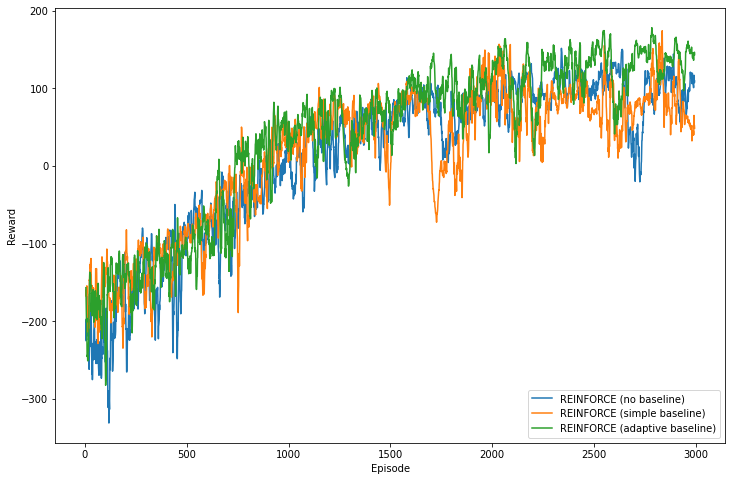

In [ ]:
# results = Results(filename="ann_experiments/final_results.npz")
episodes, agent = run_experiment("REINFORCE (adaptive baseline)",
                                  discrete_env, num_episodes, policy_learning_rate=0.002, 
                                  value_learning_rate=0.01, baseline='adaptive')
# results.save("ann_experiments/final_results")

As expected, the network using an adaptive baseline achieves the best results in the experiments that we run.
In the appendix, you can find the best results we got with the network using an adaptive baseline.

In [ ]:
agent.value_net.save('ann_experiment/model/value_net.h5')
model_json = agent.value_net.to_json()

with open("ann_experiments/model/value_net.json", 'w') as file:
    file.write(model_json)

## Exercise 3: Visualizing the Value Function

### Description

Ideally, our value network should have learned to predict the relative values across the input space. We can test this by plotting the value prediction for different observations.

1. Write a function to plot the value network prediction across [x,y] space for given (constant) values of the other state variables. X is always in [-1,1], and Y generally lies in [-0.2,1], where the landing pad is at [0,0]. (`plt.imshow`, `plt.title`, and `plt.colorbar` can be useful)
2. Plot (with titles specifying the state variable combinations) the values for 5-6 combinations of the other 6 state variables, including [0,0,0,0,0,0]. The X and Y velocity are generally within [-1,1], the angle is in [-pi,pi] and the angular velocity lies roughly within [-3,3]. The last two inputs indicating whether the legs have touched the ground are 0 (False) or 1 (True). Include two combinations with (one of the) state variables out of these ranges. Use the same color bar limits across the graphs so that they can be compared easily. 
3. Answer the question below in max. 2-3 sentence(s).

**Mark breakdown: 3 points total**
- 3 points for the plots of the value function and answering the question below.

### Solution

In [ ]:
from keras.models import model_from_json

model_file = open('ann_experiments/model/value_net.json', 'r')
model_json = model_file.read()
model_file.close()

loaded_model = model_from_json(model_json)
loaded_model.load_weights('ann_experiment/model/value_net.h5')

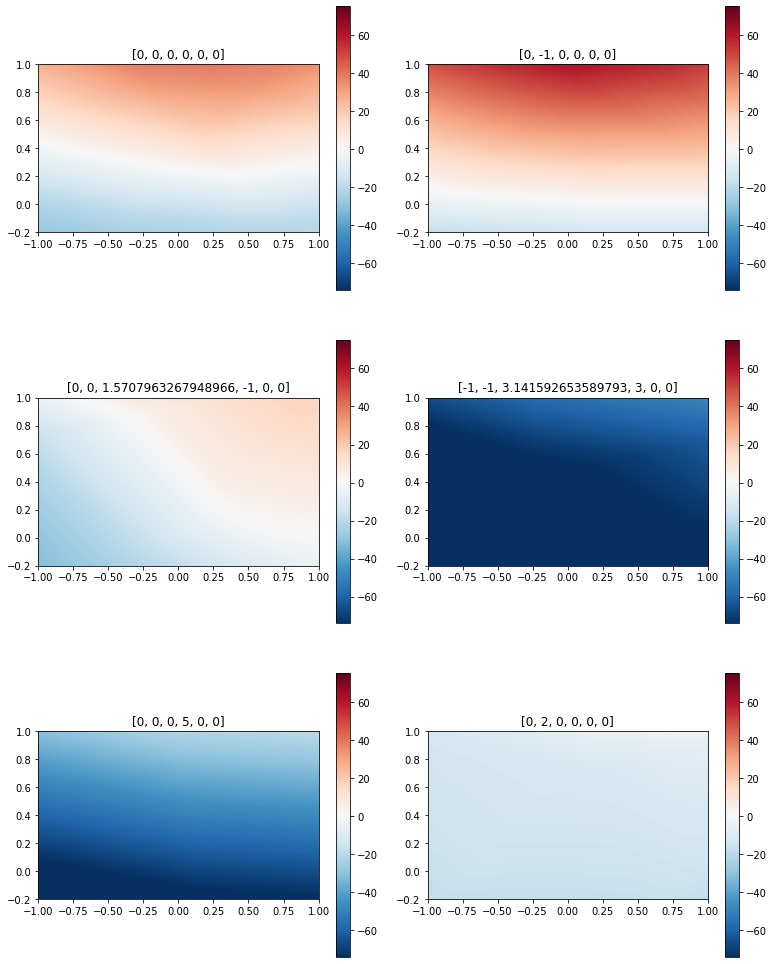

In [ ]:
import matplotlib.cm as cmap

def plot_value_pred(step, param_list):
    param_c = len(param_list)
    
    # Get number of rows and columns
    fig_col_c = 2
    fig_row_c = param_c // fig_col_c
    
    # Setup plot
    fig, axs = plt.subplots(fig_row_c, fig_col_c, figsize=(5.5*fig_col_c, 4.5*fig_row_c))
    
    for idx, params in enumerate(param_list):
        # Create grid
        x_range = np.arange(-1, 1, step)
        y_range = np.arange(-0.2, 1, step)
        pos_array = np.array(np.meshgrid(x_range, y_range, indexing='ij')).T
        
        # Create inputs for the value net
        row_size = pos_array.shape[1]
        pos_array = pos_array.reshape(-1,2)
        params_array = np.repeat(np.expand_dims(np.array(list(params.values())), 0), len(pos_array), axis=0)
        state_array = np.hstack((pos_array, params_array))
        
        # Predict with the value net
        out = loaded_model.predict(state_array)
        plot_data = out.reshape(-1, row_size)
        
        # Plot in the correct subplot
        subfig_row = idx // fig_col_c
        subfig_col = idx - subfig_row * fig_col_c
        
        ax = axs[subfig_row, subfig_col]
        c = ax.imshow(plot_data, cmap='RdBu_r',
                      vmin=-74, vmax=75,
                      extent=[-1, 1, -0.2, 1],
                      interpolation='nearest', origin='lower')
        ax.set_title(str(list(params.values())))
        fig.colorbar(c, ax=ax)
    
    fig.tight_layout(h_pad=5)
    plt.show()


params = [
    {
        "x_velocity": 0,
        "y_velocity": 0,
        "angle": 0,
        "angular_velocity": 0,
        "left_leg": 0,
        "right_leg": 0
    },
    {
        "x_velocity": 0,
        "y_velocity": -1,
        "angle": 0,
        "angular_velocity": 0,
        "left_leg": 0,
        "right_leg": 0
    },
    {
        "x_velocity": 0,
        "y_velocity": 0,
        "angle": math.pi / 2,
        "angular_velocity": -1,
        "left_leg": 0,
        "right_leg": 0
    }, 
    {
        "x_velocity": -1,
        "y_velocity": -1,
        "angle":  math.pi,
        "angular_velocity": 3,
        "left_leg": 0,
        "right_leg": 0
    },
    {
        "x_velocity": 0,
        "y_velocity": 0,
        "angle": 0,
        "angular_velocity": 5,
        "left_leg": 0,
        "right_leg": 0
    },
    {
        "x_velocity": 0,
        "y_velocity": 2,
        "angle": 0,
        "angular_velocity": 0,
        "left_leg": 0,
        "right_leg": 0,
    }
]


plot_value_pred(0.01, params)

**Question**: Does your value map for the state variables combination [0,0,0,0,0,0] make sense? What about the value maps for the combinations with state variables out of the ranges above?

**Answer**: For the state [0,0,0,0,0,0], it is expected that the value is larger on the top because, in addition to the final reward, the agent also gets a reward to get near to (0, 0). However, we noticed that the value net probably underestimates the V values. Also the last two plots, with out-of-range values, make sense because, on the left the agent rotates too fast to be able to eventually stabilize, while on the right the agent is still able to land, but using a large amount of fuel.


## Exercise 4: Comparing Architectures
### Descrition

Choosing a good neural network architecture is always a tricky question - on one hand, you want a complex architecture that is flexible enough to be able to solve the task, and on the other hand, you want to train your network as fast as possible and to not overuse your computational power. In the previous sections, we asked you to create a network with 3 hidden layers which you saw that is able to successfully solve the task and play the game. What happens if we do the same with 1 or 2 hidden layers? In this exercise, we ask you to look into the effect of the architecture and to compare different models with each other.

1. Include an extra parameter `num_layers` in the RLAgent class (by default it is equal to 3).
2. Change the `_build_network` function so that it creates a policy and value networks with the required number of layers.
3. Compare (on the same axes) the resulting plots for num_layers = 1, 2, 3.

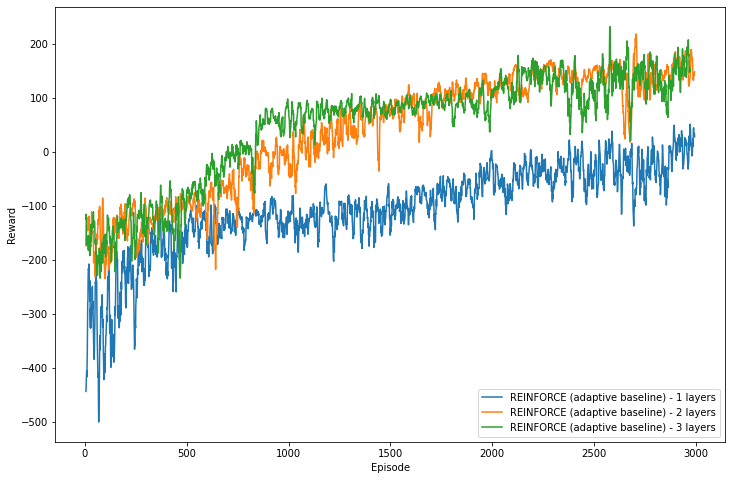

In [ ]:
results = Results()
policy_learning_rate = 0.002
value_learning_rate = 0.01
for layers in range(1, 4):
    episodes, d_model = run_experiment(f"REINFORCE (adaptive baseline) - {layers} layers",
                                      discrete_env, num_episodes, policy_learning_rate, 
                                      value_learning_rate, baseline='adaptive', num_layers=layers)
    results.save("ann_experiments/results_layers")

From the plot, we can notice a big difference in the performance of the network with 1 layer and the one with 2 layers. This highlights a gap in expressivity power of the two networks. However, the performance of the networks having 2 and 3 layers are much closer. 

## For your Interest..

The code you've written above can be easily adapted for other environments in Gym. If you like, try playing around with different environments and network structures!

# Appendix

## Hyperparameters sweep

We performed a grid search over some hyperparameters depending on the experiment. The results follow.

In [ ]:
def process_results(results, w):
    """ This function helps us to compare the results we get from a grid search 
        by computing the mean reward and the standard deviation of the reward
        over the last w steps of the training
    """
    for key, values in results.items():
        print(f"{key}: mean_reward={values[-w:].mean()}, std={values[-w:].std()}")

### No baseline

For the no baseline experiment, we run a grid search over the policy learning rates.

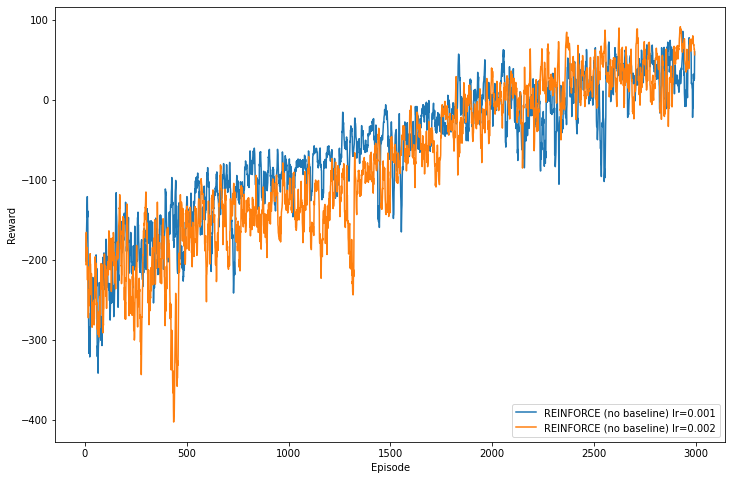

In [ ]:
results = Results()
learning_rates = [0.001, 0.002]

for lr in learning_rates:
    run_experiment(f"REINFORCE (no baseline) lr={lr}", discrete_env, num_episodes, lr)
    results.save("ann_experiments/results_none_nostd")

In [ ]:
results = Results(filename="ann_experiments/results_none_nostd.npz")
process_results(results, w=200)

REINFORCE (no baseline) lr=0.001: mean_reward=33.93790683142445, std=90.1882596605755
REINFORCE (no baseline) lr=0.002: mean_reward=43.41712107205203, std=71.18937438437011


### Simple baseline

For the simple baseline experiment, we run a grid search over the policy learning rate and the exponential decay of the moving average.

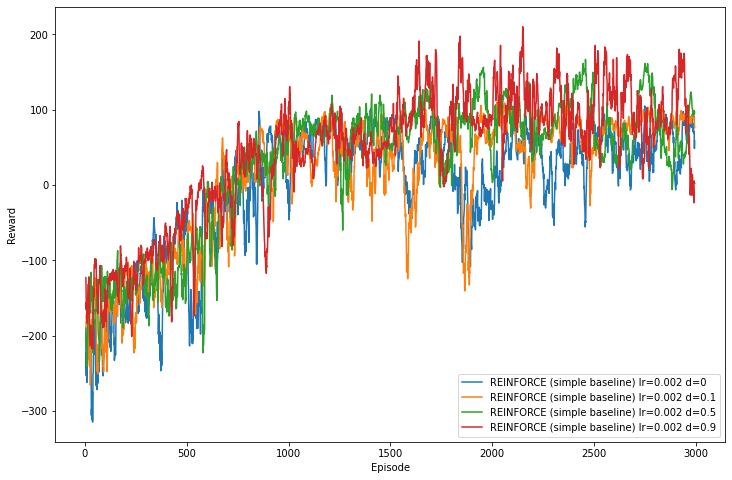

In [ ]:
results = Results()
learning_rates = [0.002]
mean_decays = [0, 0.1, 0.5, 0.9]

for lr in learning_rates:
    for d in mean_decays:
        run_experiment(f"REINFORCE (simple baseline) lr={lr} d={d}", discrete_env, num_episodes, policy_learning_rate=lr, baseline='simple', mean_decay=d)
        results.save("ann_experiments/results_simple_nostd_noGamma")

In [ ]:
results = Results(filename="ann_experiments/results_simple_nostd.npz")
process_results(results, w=200)

REINFORCE (simple baseline) lr=0.002 d=0: mean_reward=65.06000466843207, std=53.62821388539558
REINFORCE (simple baseline) lr=0.002 d=0.1: mean_reward=84.36746975503684, std=29.828461775031943
REINFORCE (simple baseline) lr=0.002 d=0.5: mean_reward=59.67076838165989, std=55.45842912503955
REINFORCE (simple baseline) lr=0.002 d=0.9: mean_reward=91.49901334985272, std=86.64310232921582


### Adaptive baseline

For the adaptive baseline experiment, we run a grid search over the policy learning rate and the value net learning rate.

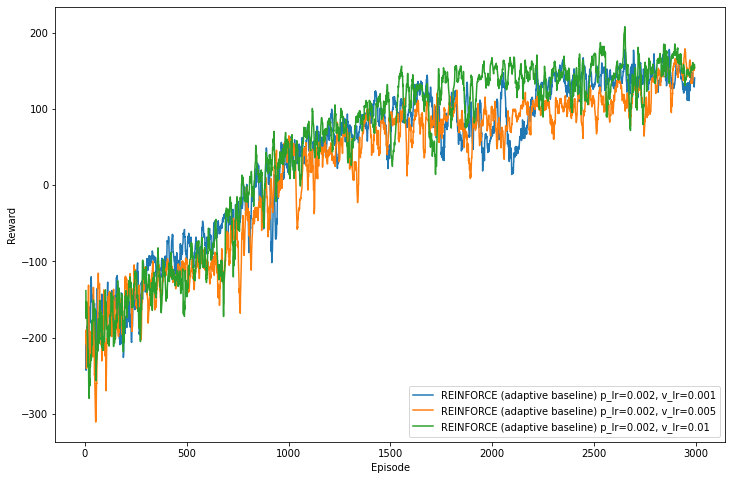

In [ ]:
results = Results()
policy_learning_rates =[0.002]
value_learning_rates = [0.001, 0.005, 0.01]

for plr in policy_learning_rates:
    for vlr in value_learning_rates:
        run_experiment(f"REINFORCE (adaptive baseline) p_lr={plr}, v_lr={vlr}",
                                        discrete_env, num_episodes, policy_learning_rate=0.002, 
                                        value_learning_rate=vlr, baseline='adaptive')
        results.save("ann_experiments/results_adaptive_nostd")

In [ ]:
results = Results(filename="ann_experiments/results_adaptive_nostd.npz")
process_results(results, 200)

REINFORCE (adaptive baseline) p_lr=0.002, v_lr=0.001: mean_reward=142.070962769597, std=44.3042036992254
REINFORCE (adaptive baseline) p_lr=0.002, v_lr=0.005: mean_reward=148.66706686954646, std=43.009149755235164
REINFORCE (adaptive baseline) p_lr=0.002, v_lr=0.01: mean_reward=157.65814456095987, std=41.57564757210877


#### Best result

What follows is the best result we have ever obtained, with a reward (in the last episodes of the experiment) very close to the maximum achievable i.e. 250. We got it by using an adaptive baseline, a learning rate of 0.002 for the policy network and a learning rate of 0.01 for the value network. In addtion, we standardized the returns before subtracting the baseline. 

Even though these results are close to perfection, we decided to not use them in the comparison with the other experiments since the standardization of the returns flattens the difference between the agents using a simple baseline and no baseline at all. Still, we provide a plot of the training below to show what is the maximum expressivity of our network.

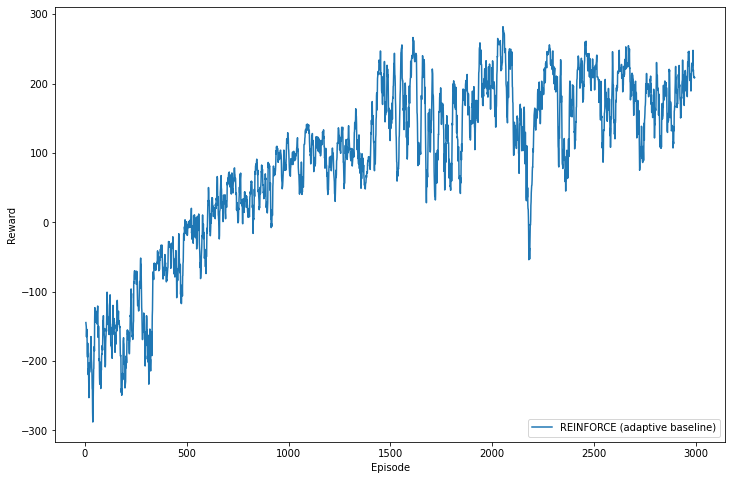

Landed 1083 times
at [1327, 1330, 1335, 1343, 1345, 1347, 1350, 1354, 1357, 1358, 1360, 1362, 1365, 1393, 1407, 1409, 1410, 1412, 1414, 1415, 1416, 1419, 1420, 1421, 1424, 1428, 1429, 1430, 1433, 1434, 1435, 1437, 1438, 1440, 1441, 1442, 1443, 1444, 1445, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1455, 1456, 1457, 1459, 1460, 1461, 1463, 1464, 1465, 1467, 1468, 1469, 1471, 1472, 1473, 1474, 1475, 1476, 1480, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1492, 1494, 1497, 1499, 1501, 1503, 1505, 1507, 1508, 1510, 1512, 1513, 1514, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1528, 1539, 1544, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1564, 1565, 1566, 1569, 1570, 1572, 1573, 1574, 1576, 1577, 1578, 1579, 1582, 1585, 1589, 1590, 1592, 1593, 1594, 1596, 1597, 1598, 1600, 1601, 1602, 1603, 1604, 1605, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 

In [ ]:
results = Results()
episodes, agent = run_experiment("REINFORCE (adaptive baseline)",
                                  discrete_env, num_episodes, policy_learning_rate=0.002,
                                  value_learning_rate=0.01, baseline='adaptive')